In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
import statsmodels.formula.api as smf

RAND = 123
K = 5

In [4]:
df = pd.read_csv(r"D:\DataScience\Projects\Cardio\data\data_cleaned\data_cleaned.csv")

## 02 Feature_vs_Target_Visualization

Корреляция age-cardio:
         cardio      age
cardio  1.00000  0.23956
age     0.23956  1.00000



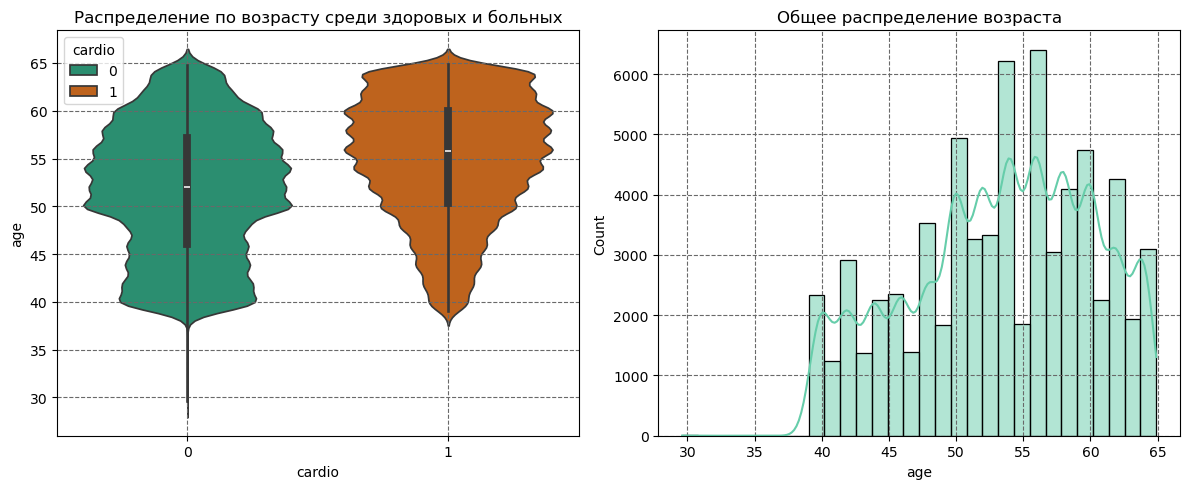

In [23]:
print(f"Корреляция age-cardio:")
print(f"{df[['cardio', 'age']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='age', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение по возрасту среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.histplot(df, x='age', bins=30, kde=True, color='mediumaquamarine', ax=ax[1])
ax[1].set_title("Общее распределение возраста")
ax[1].grid(color='dimgray', linestyle='--')

plt.tight_layout()
plt.show()

На графике отчётливо прослеживается прямая зависимость между возрастом и наличием заболевания: с увеличением возраста растёт и вероятность болезни. Однако степень этой зависимости нельзя назвать значительной, что подтверждается относительно низким коэффициентом корреляции.

Дисбаланс классов по gender (в %):
gender
1    65.1
2    34.9
Name: proportion, dtype: float64

Корреляция gender-cardio:
          cardio    gender
cardio  1.000000  0.007067
gender  0.007067  1.000000



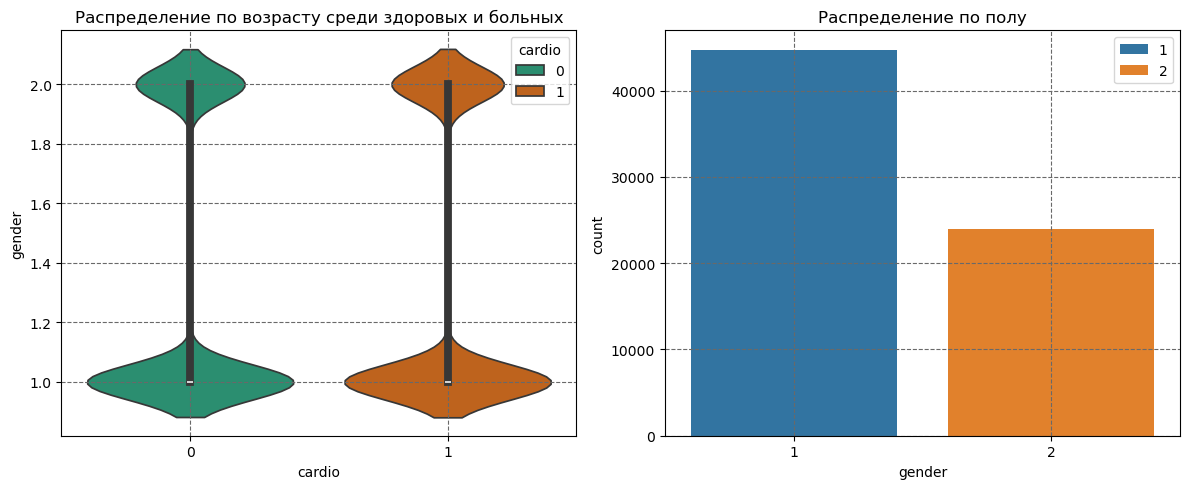

In [39]:
print(f"Дисбаланс классов по gender (в %):")
print(f"{round(df.gender.value_counts(normalize=True)*100,1)}\n")
print(f"Корреляция gender-cardio:")
print(f"{df[['cardio', 'gender']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='gender', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение по возрасту среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='gender', hue='gender', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по полу")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

На графике не наблюдается выраженной зависимости между полом испытуемого и наличием заболевания. Этот вывод подтверждается и коэффициентом корреляции. Более широкое распределение у женщин, вероятно, связано с незначительным дисбалансом классов.

Корреляция height-cardio:
          cardio    height
cardio  1.000000 -0.011736
height -0.011736  1.000000



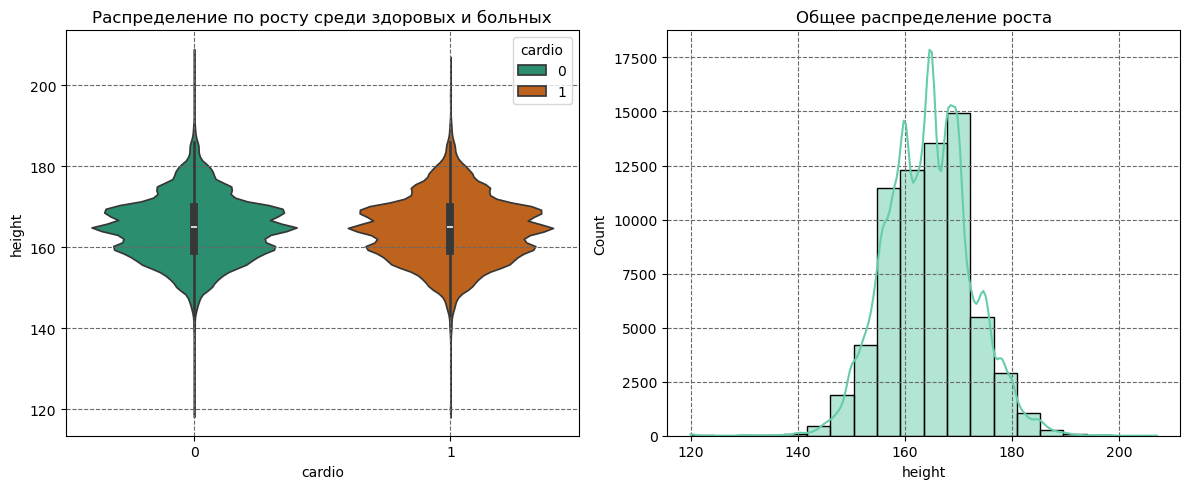

In [44]:
print(f"Корреляция height-cardio:")
print(f"{df[['cardio', 'height']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='height', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение по росту среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.histplot(df, x='height', bins=20, kde=True, color='mediumaquamarine', ax=ax[1])
ax[1].set_title("Общее распределение роста")
ax[1].grid(color='dimgray', linestyle='--')

plt.tight_layout()
plt.show()

Разумеется, я не ожидал обнаружить зависимость наличия заболевания от роста — построил этот график скорее ради душевного спокойствия 😄. Коэффициент корреляции близок к нулю, распределения практически идентичны — зависимости нет. Что и требовалось доказать!

Корреляция weight-cardio:
          cardio    weight
cardio  1.000000  0.179891
weight  0.179891  1.000000



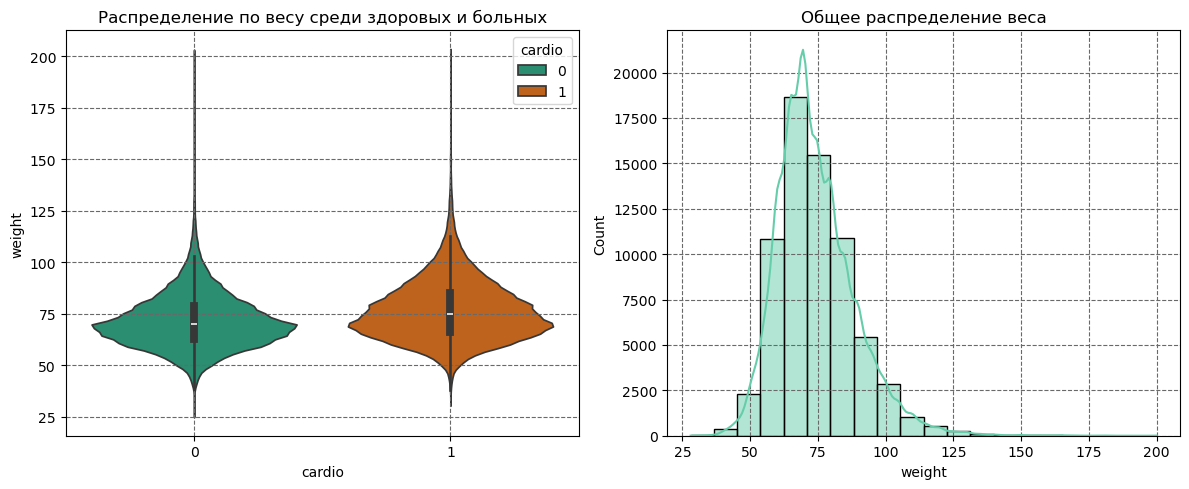

In [46]:
print(f"Корреляция weight-cardio:")
print(f"{df[['cardio', 'weight']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='weight', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение по весу среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.histplot(df, x='weight', bins=20, kde=True, color='mediumaquamarine', ax=ax[1])
ax[1].set_title("Общее распределение веса")
ax[1].grid(color='dimgray', linestyle='--')

plt.tight_layout()
plt.show()

К моему удивлению, чёткой зависимости наличия заболевания от веса не прослеживается. Коэффициент корреляции — незначительный. Да, у положительно маркированных испытуемых появляется вторая вершина в распределении, из-за чего среднее значение веса немного выше, чем у здоровых. Но разница слишком мала, чтобы делать выводы… Или всё же стоит проверить это с помощью теста значимости?

Для начала проверим распределения веса среди положительно и отрицательно маркированных испытуемых на нормальность с помощью теста `Д’Агостино — Пирсона`.

In [47]:
group_sick = df.weight[df.cardio == 1]
group_healthy = df.weight[df.cardio == 0]

print(normaltest(group_sick))
print(normaltest(group_healthy))

NormaltestResult(statistic=5470.9912051672445, pvalue=0.0)
NormaltestResult(statistic=6236.46777736502, pvalue=0.0)


`P-value` в обеих группах стремится к нулю, что указывает на отклонение от нормальности. Поэтому для оценки значимости различий между группами применим непараметрический тест `Манна — Уитни`.

Гипотезы:

* `H₀`: Статистически значимая разница между группами отсутствует.

* `H₁`: Между группами существует статистически значимая разница.

In [48]:
u_stat, p_value = mannwhitneyu(group_sick, group_healthy)
print(f"U-статистика: {u_stat}")
print(f"p-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print(f"Отвергаем нулевую гипотезу: между  группами существует статистически значимая разница.")
else:
    print(f"Нулевую гипотезу отвергать нельзя: различий между группами нет.")

U-статистика: 712420615.5
p-value: 0.0
Отвергаем нулевую гипотезу: между  группами существует статистически значимая разница.


Ага! Всё-таки не зря я хожу в спортзал 😄 **Статистически значимая разница** между группами действительно **есть**. Это может свидетельствовать о том, что лишний вес увеличивает вероятность развития сердечно-сосудистого заболевания.

**Далее выдвигаю гипотезу**: `возраст` и `корпулентность` **в совокупности** являются более значимым признаком для обнаружения сердечно-сосудистого заболевания.

Воспользуюсь логистической регрессией, чтобы оценить влияние совокупного признака на вероятность сердечно-сосудистого заболевания.

In [49]:
model = smf.logit("cardio ~ age + weight + age:weight", data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.647831
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68684
Model:                          Logit   Df Residuals:                    68680
Method:                           MLE   Df Model:                            3
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                 0.06530
Time:                        18:24:13   Log-Likelihood:                -44496.
converged:                       True   LL-Null:                       -47604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.5188      0.361    -26.402      0.000     -10.225      -8.812
age            0.1422      0.

In [50]:
model = smf.logit("cardio ~ age + weight", data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.648634
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68684
Model:                          Logit   Df Residuals:                    68681
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                 0.06414
Time:                        18:24:15   Log-Likelihood:                -44551.
converged:                       True   LL-Null:                       -47604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8631      0.080    -73.342      0.000      -6.020      -5.706
age            0.0734      0.

К сожалению, значения `Pseudo R²` оказались практически идентичными. На данном этапе гипотеза не подтверждается. Вернусь к ней позже — при обучении моделей `Random Forest` и `нейронной сети`.

Корреляция ap_hi-cardio:
          cardio     ap_hi
cardio  1.000000  0.426847
ap_hi   0.426847  1.000000



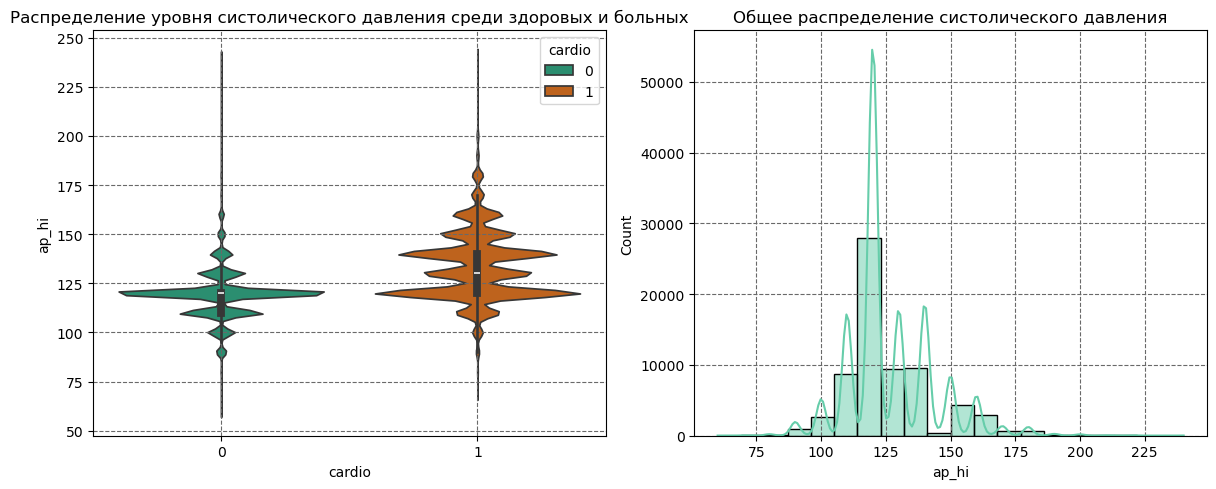

In [62]:
print(f"Корреляция ap_hi-cardio:")
print(f"{df[['cardio', 'ap_hi']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='ap_hi', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение уровня систолического давления среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.histplot(df, x='ap_hi', bins=20, kde=True, color='mediumaquamarine', ax=ax[1])
ax[1].set_title("Общее распределение систолического давления")
ax[1].grid(color='dimgray', linestyle='--')

plt.tight_layout()
plt.show()

В группе положительно маркированных испытуемых систолическое давление заметно выше. Коэффициент корреляции находится на среднем уровне, что указывает на наличие связи между систолическим давлением и вероятностью сердечно-сосудистого заболевания.

Корреляция ap_lo-cardio:
          cardio     ap_lo
cardio  1.000000  0.337994
ap_lo   0.337994  1.000000



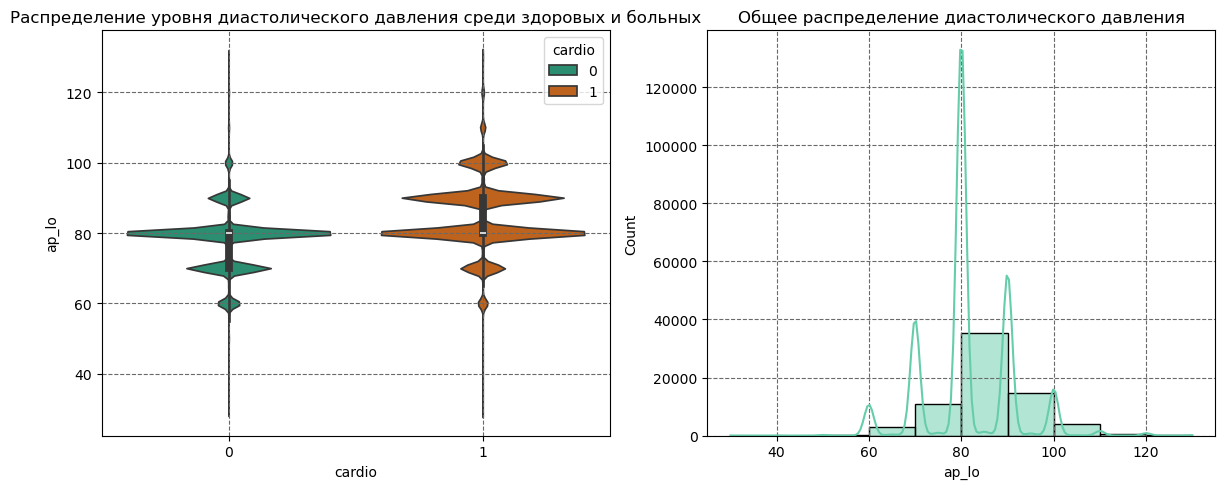

In [64]:
print(f"Корреляция ap_lo-cardio:")
print(f"{df[['cardio', 'ap_lo']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='ap_lo', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение уровня диастолического давления среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.histplot(df, x='ap_lo', bins=10, kde=True, color='mediumaquamarine', ax=ax[1])
ax[1].set_title("Общее распределение диастолического давления")
ax[1].grid(color='dimgray', linestyle='--')

plt.tight_layout()
plt.show()


Диастолическое давление демонстрирует схожую динамику с систолическим, однако коэффициент корреляции с целевой переменной немного ниже.

Корреляция cholesterol-cardio:
               cardio  cholesterol
cardio       1.000000     0.221488
cholesterol  0.221488     1.000000



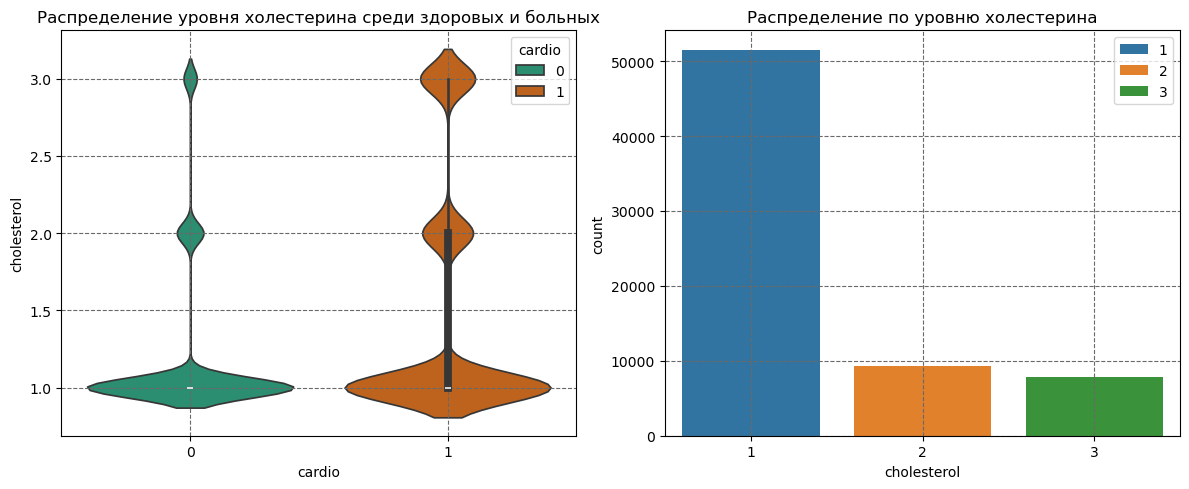

In [66]:
print(f"Корреляция cholesterol-cardio:")
print(f"{df[['cardio', 'cholesterol']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='cholesterol', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение уровня холестерина среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='cholesterol', hue='cholesterol', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по уровню холестерина")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

Распределения данных по холестерину у пациентов с положительной маркировкой (наличием заболевания) оказываются шире и выше во всех категориях. Это может свидетельствовать о том, что повышенный уровень холестерина связан с повышенной вероятностью сердечно-сосудистых заболеваний.

Корреляция gluc-cardio:
         cardio     gluc
cardio  1.00000  0.08988
gluc    0.08988  1.00000



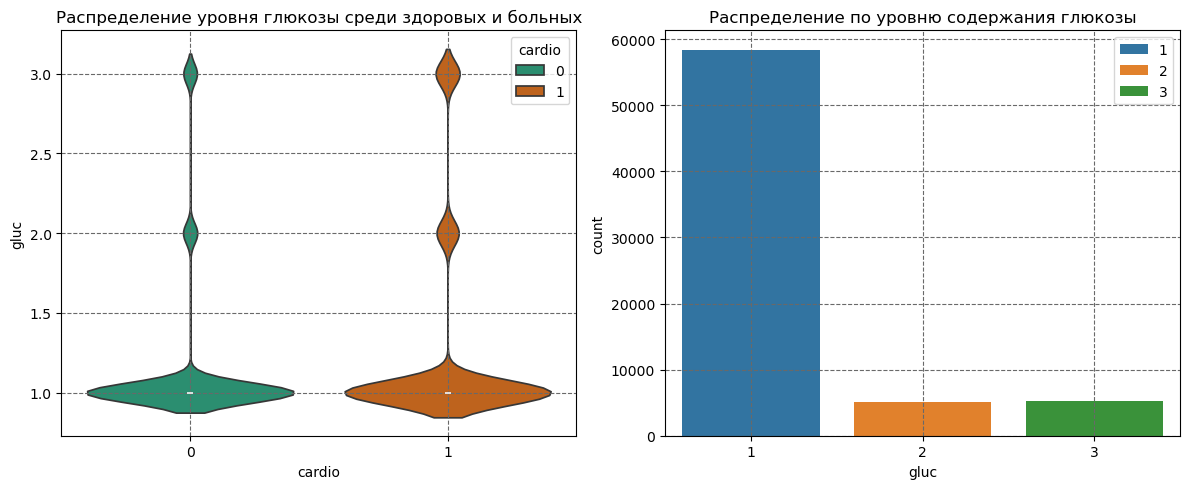

In [67]:
print(f"Корреляция gluc-cardio:")
print(f"{df[['cardio', 'gluc']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='gluc', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение уровня глюкозы среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='gluc', hue='gluc', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по уровню содержания глюкозы")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

Данные по глюкозе схожи с данными по холестерину. Замечу, что коэффициент корреляции по глюкозе ниже, чем по холестерину.

Корреляция smoke-cardio:
          cardio     smoke
cardio  1.000000 -0.016312
smoke  -0.016312  1.000000



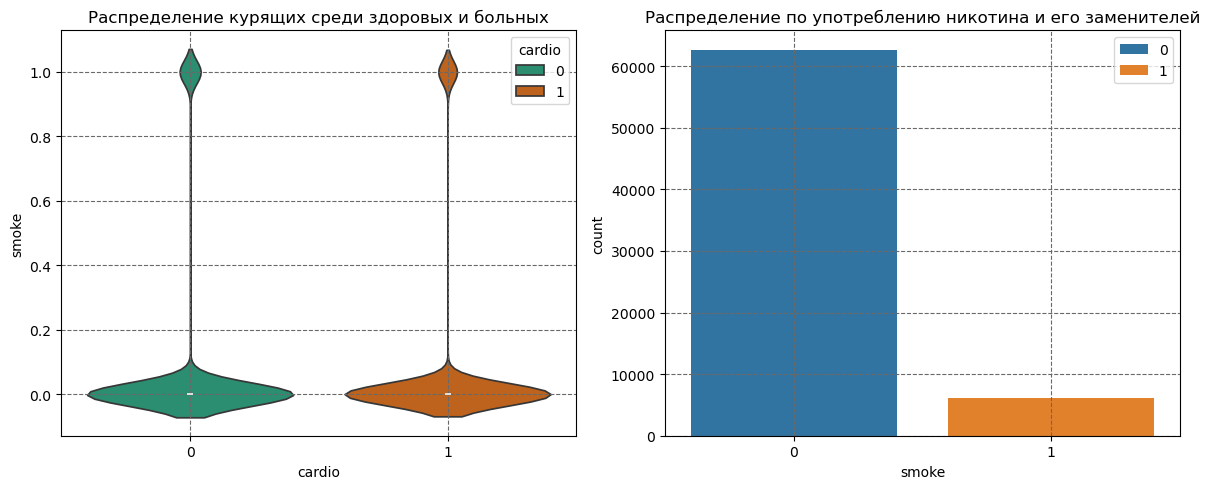

In [69]:
print(f"Корреляция smoke-cardio:")
print(f"{df[['cardio', 'smoke']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='smoke', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение курящих среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='smoke', hue='smoke', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по употреблению никотина и его заменителей")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

Курение, как ни странно, практически не влияет на вероятность заболевания. Это удивляет, учитывая общеизвестные медицинские данные.

Корреляция alco-cardio:
          cardio      alco
cardio  1.000000 -0.008702
alco   -0.008702  1.000000



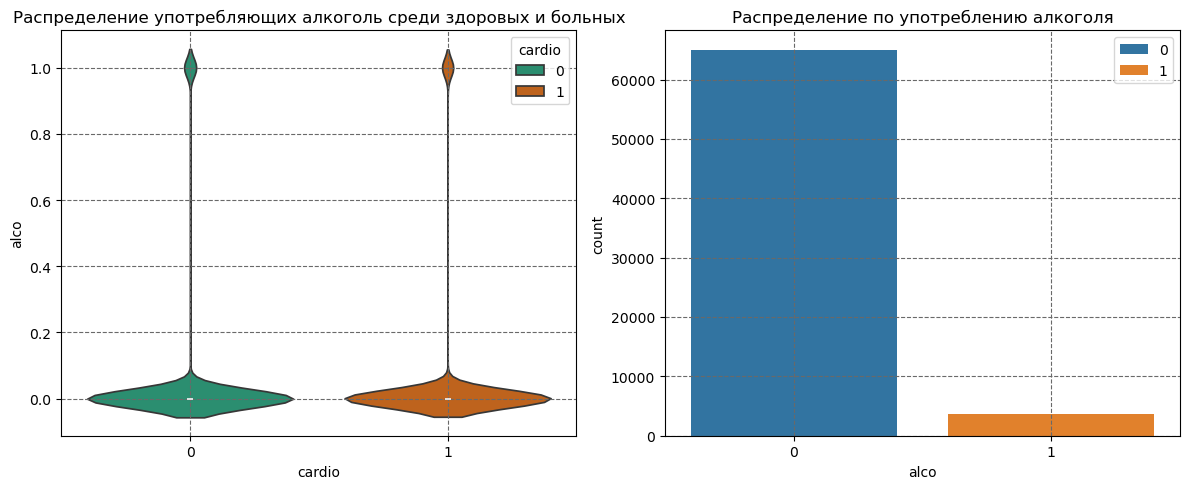

In [70]:
print(f"Корреляция alco-cardio:")
print(f"{df[['cardio', 'alco']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='alco', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение употребляющих алкоголь среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='alco', hue='alco', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по употреблению алкоголя")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

Употребление алкоголя практически не влияет на вероятность заболевания. Это удивляет, учитывая известные медицинские риски. Возможно, влияние алкоголя опосредовано другими признаками или недостаточно выражено в данной выборке.

Корреляция active-cardio:
          cardio    active
cardio  1.000000 -0.037509
active -0.037509  1.000000



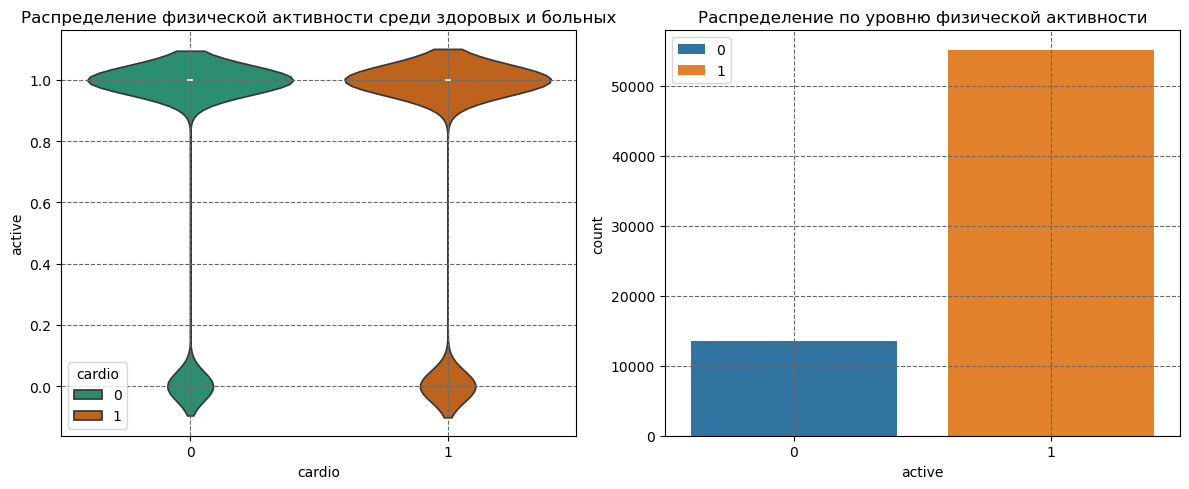

In [74]:
print(f"Корреляция active-cardio:")
print(f"{df[['cardio', 'active']].corr()}\n")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(df, x='cardio', y='active', hue='cardio', palette='Dark2', ax=ax[0])
ax[0].set_title("Распределение физической активности среди здоровых и больных")
ax[0].grid(color='dimgray', linestyle='--')

sns.countplot(df, x='active', hue='active', palette='tab10', ax=ax[1])
ax[1].set_title("Распределение по уровню физической активности")
ax[1].grid(color='dimgray', linestyle='--')
ax[1].legend()

plt.tight_layout()
plt.show()

А вот наличие физической активности, судя по распределениям и корреляции, немного повышает риск заболевания!

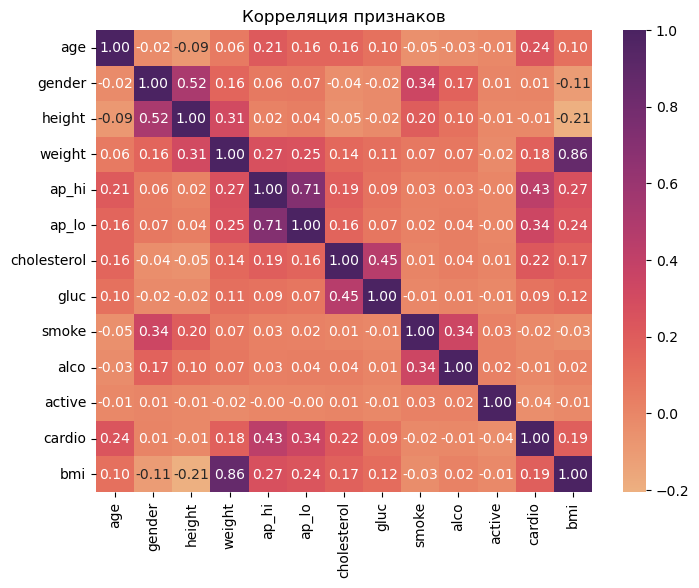

In [84]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='flare', fmt='.2f')
plt.title('Корреляция признаков')
plt.show()